In [203]:
import pandas as pd
import numpy as np
import requests

uri = "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv"

r = requests.get(uri)
with open('dados/simulacao-caros.csv', 'wb') as f:
    f.write(r.content)


dados = pd.read_csv(uri).drop(columns=["Unnamed: 0"], axis=1)
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


In [204]:
# situação horrível de "azar" onde as classes estão ordenadas por padrão

dados_azar = dados.sort_values("vendido", ascending=True)
x_azar = dados_azar[["preco", "idade_do_modelo","km_por_ano"]]
y_azar = dados_azar["vendido"]
dados_azar.head()

,preco,vendido,idade_do_modelo,km_por_ano
4999,74023.29,0,12,24812.80412
5322,84843.49,0,13,23095.63834
5319,83100.27,0,19,36240.72746
5316,87932.13,0,16,32249.56426
5315,77937.01,0,15,28414.50704


In [205]:
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier

SEED = 301
np.random.seed(SEED)

modelo = DummyClassifier()
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com dummy stratified, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com dummy stratified, 10 = [49.79, 53.45]


In [206]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier

SEED = 301
np.random.seed(SEED)

modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com cross validation, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com cross validation, 10 = [73.83, 77.73]


In [207]:
# gerando dados elatorios de modelo de carro para simulacao de agrupamento ao usar nosso estimador

np.random.seed(SEED)
dados['modelo'] = dados.idade_do_modelo + np.random.randint(-2, 3, size=10000)
dados.modelo = dados.modelo + abs(dados.modelo.min()) + 1
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano,modelo
0,30941.02,1,18,35085.22134,18
1,40557.96,1,20,12622.05362,24
2,89627.50,0,12,11440.79806,14
3,95276.14,0,3,43167.32682,6
4,117384.68,1,4,12770.11290,5


In [208]:
def imprime_resultados(results):
  media = results['test_score'].mean() * 100
  desvio = results['test_score'].std() * 100
  print("Accuracy médio %.2f" % media)
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

In [209]:
# GroupKFold em um pipeline com StandardScaler e SVC

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

SEED = 301
np.random.seed(SEED)

scaler = StandardScaler()
modelo = SVC()

pipeline = Pipeline([('transformacao',scaler), ('estimador',modelo)])

cv = GroupKFold(n_splits = 10)
results = cross_validate(pipeline, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 76.68
Intervalo [74.28, 79.08]


In [210]:
# GroupKFold para analisar como o modelo se comporta com novos grupos

from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 75.78
Intervalo [73.67, 77.90]


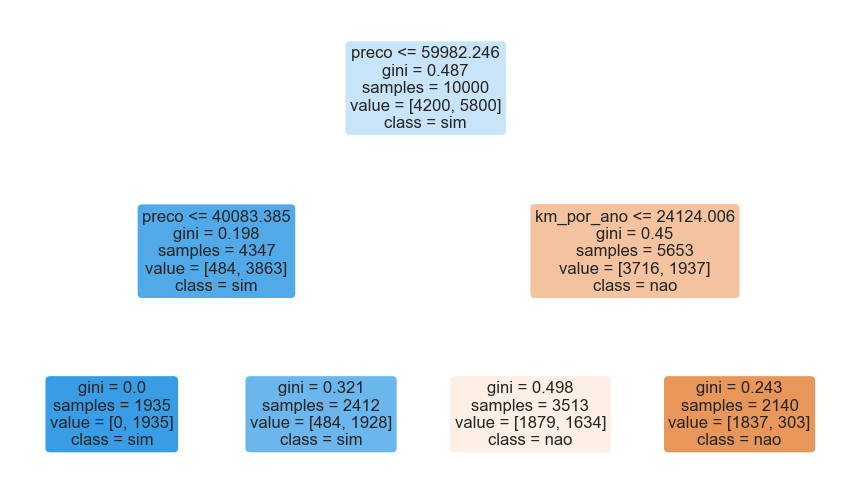

In [211]:
# Plotando arvore de decisão

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

modelo.fit(x_azar, y_azar)

plt.figure(figsize=(15,9))
plot_tree(modelo, feature_names=x_azar.columns, filled=True, class_names=['nao', 'sim'], rounded=True)
plt.show()

In [212]:
# Utilizando 3 graus de profundidade

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=3)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 78.67
Intervalo [76.40, 80.94]


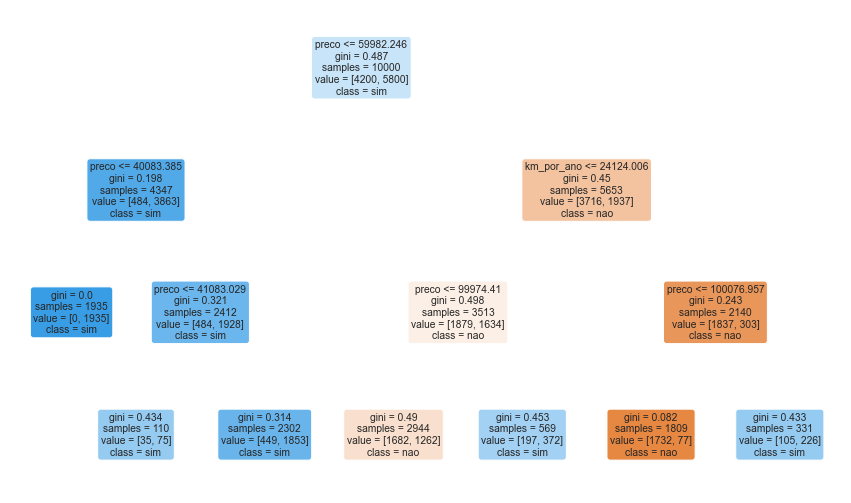

In [213]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

modelo.fit(x_azar, y_azar)

plt.figure(figsize=(15,9))
plot_tree(modelo, feature_names=x_azar.columns, filled=True, class_names=['nao', 'sim'], rounded=True)
plt.show()

# Explorando hiperparametros em 1 dimensão

In [214]:
def avalia_profundidade(max_depth):
    SEED = 301
    np.random.seed(SEED)

    cv = GroupKFold(n_splits = 10)
    modelo = DecisionTreeClassifier(max_depth=max_depth)
    results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
    media_teste = results['test_score'].mean()
    media_treino = results['train_score'].mean()
    print(f'Modelo max_depth = {max_depth}, treino = {media_treino*100:0.2f}, teste = {media_teste*100:0.2f} ')
    return [max_depth, media_treino, media_teste]

resultados = [avalia_profundidade(i) for i in range(1, 33)]
resultados = pd.DataFrame(resultados, columns = ['max_depth', 'train_score', 'test_score'])

Modelo max_depth = 1, treino = 75.79, teste = 75.78 
Modelo max_depth = 2, treino = 75.79, teste = 75.78 
Modelo max_depth = 3, treino = 78.75, teste = 78.67 
Modelo max_depth = 4, treino = 78.79, teste = 78.63 
Modelo max_depth = 5, treino = 78.94, teste = 78.56 
Modelo max_depth = 6, treino = 79.17, teste = 78.12 
Modelo max_depth = 7, treino = 79.50, teste = 77.96 
Modelo max_depth = 8, treino = 79.89, teste = 77.86 
Modelo max_depth = 9, treino = 80.46, teste = 77.38 
Modelo max_depth = 10, treino = 81.16, teste = 77.19 
Modelo max_depth = 11, treino = 82.03, teste = 76.97 
Modelo max_depth = 12, treino = 82.89, teste = 76.49 
Modelo max_depth = 13, treino = 83.95, teste = 75.81 
Modelo max_depth = 14, treino = 85.03, teste = 75.66 
Modelo max_depth = 15, treino = 86.14, teste = 75.16 
Modelo max_depth = 16, treino = 87.19, teste = 75.11 
Modelo max_depth = 17, treino = 88.31, teste = 74.74 
Modelo max_depth = 18, treino = 89.26, teste = 74.33 
Modelo max_depth = 19, treino = 90.32

In [215]:
resultados.head()

,max_depth,train_score,test_score
0,1,0.757912,0.757842
1,2,0.757912,0.757842
2,3,0.787510,0.786726
3,4,0.787876,0.786328
4,5,0.789410,0.785559


# OVERFIT: Perfeito para o treino, ruim para o teste

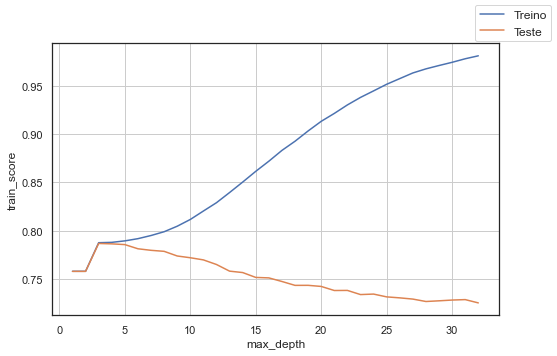

In [216]:
import seaborn as sns

fig = plt.figure(figsize=(8,5))
sns.lineplot(x = 'max_depth', y = 'train_score', data = resultados)
sns.lineplot(x = 'max_depth', y = 'test_score', data = resultados)
fig.legend(labels = [ 'Treino', 'Teste'], fontsize = 12)
plt.grid()

In [217]:
import plotly.graph_objects as go

trace1 = go.Scatter(x = resultados.max_depth, y = resultados.train_score, name = 'Treino', mode = 'lines')
trace2 = go.Scatter(x = resultados.max_depth, y = resultados.test_score, name = 'Teste', mode = 'lines')


layout = go.Layout(
    title = 'Acuracia do modelo',
    titlefont_size = 25,
    xaxis = dict(
        title = 'Profundiade',
        titlefont_size = 16
    ),
    yaxis = dict(
        title = 'Acurácia',
        titlefont_size = 16
    ),
    height = 600,
    width = 900
)
traces = [trace1, trace2]

go.Figure(traces, layout)

# Explorando hiperparametros em 2 dimensões

In [218]:
def avalia_profundidade(max_depth, min_samples_leaf):
    SEED = 301
    np.random.seed(SEED)

    cv = GroupKFold(n_splits = 10)
    modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf= min_samples_leaf)
    results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
    media_teste = results['test_score'].mean()
    media_treino = results['train_score'].mean()
    print(f'Modelo max_depth = {max_depth}, treino = {media_treino*100:0.2f}, teste = {media_teste*100:0.2f} ')
    tabela = [max_depth, min_samples_leaf, media_treino, media_teste]
    return tabela

resultados = [avalia_profundidade(i, j) for i in range(1, 33) for j in range(1, 33)]
resultados = pd.DataFrame(resultados, columns = ['max_depth', 'min_samples_leaf', 'train_score', 'test_score'])
resultados.head()

.81, teste = 76.26 
Modelo max_depth = 21, treino = 82.59, teste = 76.23 
Modelo max_depth = 21, treino = 82.45, teste = 76.14 
Modelo max_depth = 21, treino = 82.28, teste = 76.63 
Modelo max_depth = 21, treino = 82.19, teste = 76.39 
Modelo max_depth = 21, treino = 82.09, teste = 76.35 
Modelo max_depth = 21, treino = 81.95, teste = 76.22 
Modelo max_depth = 21, treino = 81.88, teste = 76.28 
Modelo max_depth = 21, treino = 81.70, teste = 76.65 
Modelo max_depth = 21, treino = 81.58, teste = 77.00 
Modelo max_depth = 21, treino = 81.50, teste = 76.95 
Modelo max_depth = 21, treino = 81.39, teste = 77.12 
Modelo max_depth = 21, treino = 81.28, teste = 77.09 
Modelo max_depth = 21, treino = 81.21, teste = 77.08 
Modelo max_depth = 21, treino = 81.14, teste = 77.06 
Modelo max_depth = 21, treino = 81.07, teste = 76.91 
Modelo max_depth = 21, treino = 80.98, teste = 77.18 
Modelo max_depth = 21, treino = 80.91, teste = 77.06 
Modelo max_depth = 21, treino = 80.88, teste = 76.92 
Modelo m

,max_depth,min_samples_leaf,train_score,test_score
0,1,1,0.757912,0.757842
1,1,2,0.757912,0.757842
2,1,3,0.757912,0.757842
3,1,4,0.757912,0.757842
4,1,5,0.757912,0.757842


In [219]:
corr = resultados.corr()
corr

,max_depth,min_samples_leaf,train_score,test_score
max_depth,1.000000,0.000000,0.681408,-0.522835
min_samples_leaf,0.000000,1.000000,-0.453825,0.528330
train_score,0.681408,-0.453825,1.000000,-0.762534
test_score,-0.522835,0.528330,-0.762534,1.000000


<AxesSubplot:>

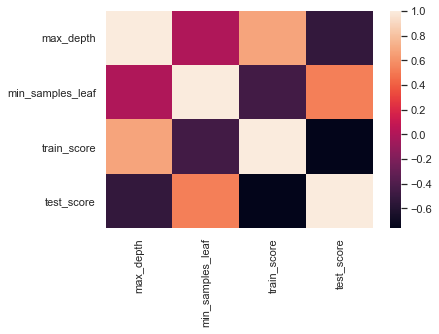

In [220]:
sns.heatmap(corr)

array([[<AxesSubplot:xlabel='max_depth', ylabel='max_depth'>,
        <AxesSubplot:xlabel='min_samples_leaf', ylabel='max_depth'>,
        <AxesSubplot:xlabel='train_score', ylabel='max_depth'>,
        <AxesSubplot:xlabel='test_score', ylabel='max_depth'>],
       [<AxesSubplot:xlabel='max_depth', ylabel='min_samples_leaf'>,
        <AxesSubplot:xlabel='min_samples_leaf', ylabel='min_samples_leaf'>,
        <AxesSubplot:xlabel='train_score', ylabel='min_samples_leaf'>,
        <AxesSubplot:xlabel='test_score', ylabel='min_samples_leaf'>],
       [<AxesSubplot:xlabel='max_depth', ylabel='train_score'>,
        <AxesSubplot:xlabel='min_samples_leaf', ylabel='train_score'>,
        <AxesSubplot:xlabel='train_score', ylabel='train_score'>,
        <AxesSubplot:xlabel='test_score', ylabel='train_score'>],
       [<AxesSubplot:xlabel='max_depth', ylabel='test_score'>,
        <AxesSubplot:xlabel='min_samples_leaf', ylabel='test_score'>,
        <AxesSubplot:xlabel='train_score', ylabel='tes

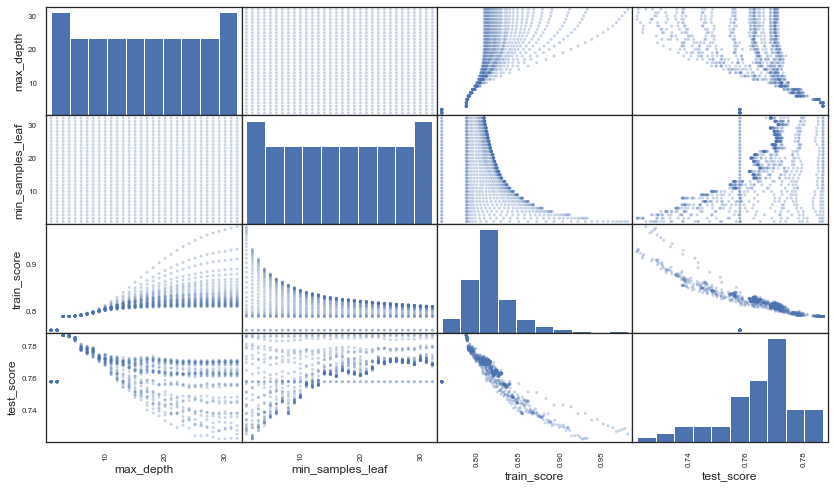

In [221]:
pd.plotting.scatter_matrix(resultados, figsize = (14,8), alpha = 0.3)

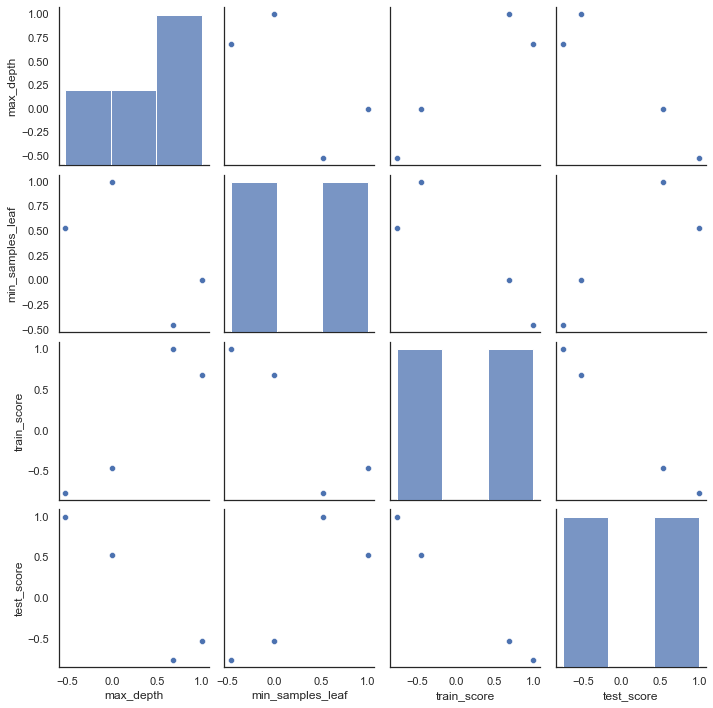

In [222]:
sns.pairplot(corr)

<AxesSubplot:>

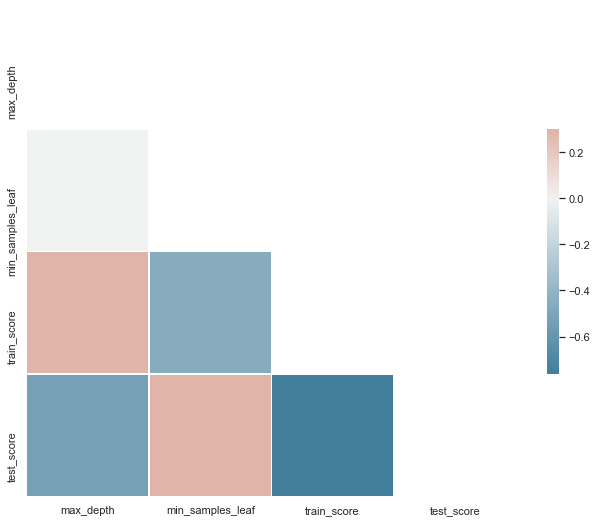

In [223]:
from string import ascii_letters

sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [224]:
resultados.sort_values(by='test_score', ascending=False)

,max_depth,min_samples_leaf,train_score,test_score
123,4,28,0.787510,0.786726
126,4,31,0.787510,0.786726
85,3,22,0.787510,0.786726
84,3,21,0.787510,0.786726
83,3,20,0.787510,0.786726
...,...,...,...,...
865,28,2,0.923863,0.723310
961,31,2,0.930448,0.722575
993,32,2,0.932447,0.722532
929,30,2,0.928126,0.722147


In [225]:
def avalia_profundidade_e_min_leafs(min_leafs : list):
    resultados = [avalia_profundidade(i, j) for i in range(1, 33) for j in min_leafs]
    resultados = pd.DataFrame(resultados, columns = ['max_depth', 'min_samples_leaf', 'train_score', 'test_score'])
    return resultados
resultados = avalia_profundidade_e_min_leafs([32,64,128,256])

Modelo max_depth = 1, treino = 75.79, teste = 75.78 
Modelo max_depth = 1, treino = 75.79, teste = 75.78 
Modelo max_depth = 1, treino = 75.79, teste = 75.78 
Modelo max_depth = 1, treino = 75.79, teste = 75.78 
Modelo max_depth = 2, treino = 75.79, teste = 75.78 
Modelo max_depth = 2, treino = 75.79, teste = 75.78 
Modelo max_depth = 2, treino = 75.79, teste = 75.78 
Modelo max_depth = 2, treino = 75.79, teste = 75.78 
Modelo max_depth = 3, treino = 78.75, teste = 78.67 
Modelo max_depth = 3, treino = 78.75, teste = 78.67 
Modelo max_depth = 3, treino = 78.75, teste = 78.67 
Modelo max_depth = 3, treino = 78.75, teste = 78.67 
Modelo max_depth = 4, treino = 78.75, teste = 78.67 
Modelo max_depth = 4, treino = 78.75, teste = 78.67 
Modelo max_depth = 4, treino = 78.75, teste = 78.67 
Modelo max_depth = 4, treino = 78.75, teste = 78.67 
Modelo max_depth = 5, treino = 78.82, teste = 78.50 
Modelo max_depth = 5, treino = 78.79, teste = 78.45 
Modelo max_depth = 5, treino = 78.77, teste = 

In [226]:
corr = resultados.corr()

<AxesSubplot:>

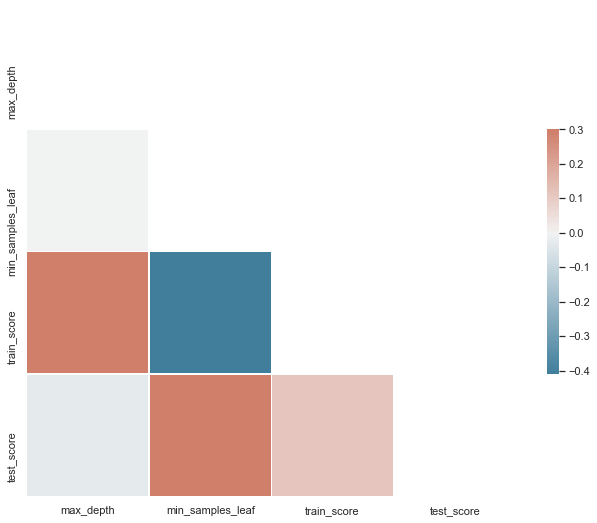

In [227]:
from string import ascii_letters

sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [228]:
resultados.sort_values(by='test_score', ascending=False)[:5]

,max_depth,min_samples_leaf,train_score,test_score
15,4,256,0.78751,0.786726
12,4,32,0.78751,0.786726
14,4,128,0.78751,0.786726
13,4,64,0.78751,0.786726
8,3,32,0.78751,0.786726


Modelo max_depth = 1, treino = 75.79, teste = 75.78 
Modelo max_depth = 1, treino = 75.79, teste = 75.78 
Modelo max_depth = 1, treino = 75.79, teste = 75.78 
Modelo max_depth = 1, treino = 75.79, teste = 75.78 
Modelo max_depth = 2, treino = 75.79, teste = 75.78 
Modelo max_depth = 2, treino = 75.79, teste = 75.78 
Modelo max_depth = 2, treino = 75.79, teste = 75.78 
Modelo max_depth = 2, treino = 75.79, teste = 75.78 
Modelo max_depth = 3, treino = 78.75, teste = 78.67 
Modelo max_depth = 3, treino = 78.75, teste = 78.67 
Modelo max_depth = 3, treino = 78.75, teste = 78.67 
Modelo max_depth = 3, treino = 77.53, teste = 77.50 
Modelo max_depth = 4, treino = 78.75, teste = 78.67 
Modelo max_depth = 4, treino = 78.75, teste = 78.67 
Modelo max_depth = 4, treino = 78.75, teste = 78.67 
Modelo max_depth = 4, treino = 77.53, teste = 77.50 
Modelo max_depth = 5, treino = 78.77, teste = 78.44 
Modelo max_depth = 5, treino = 78.77, teste = 78.44 
Modelo max_depth = 5, treino = 78.77, teste = 

<AxesSubplot:>

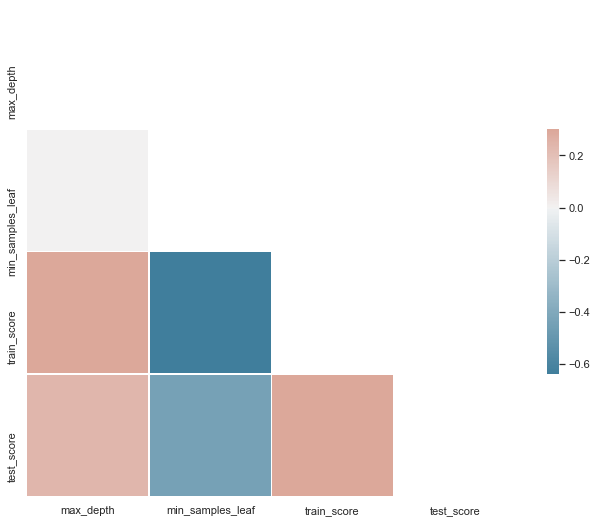

In [229]:
resultados = avalia_profundidade_e_min_leafs([128,192,256,512])
corr = resultados.corr()

from string import ascii_letters

sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [230]:
resultados.sort_values(by='test_score', ascending=False)[:5]

,max_depth,min_samples_leaf,train_score,test_score
13,4,192,0.78751,0.786726
8,3,128,0.78751,0.786726
9,3,192,0.78751,0.786726
10,3,256,0.78751,0.786726
14,4,256,0.78751,0.786726


# Explorando 3 hiperparametros

In [231]:
def avalia_profundidade(max_depth, min_samples_leaf, min_samples_split):
    SEED = 301
    np.random.seed(SEED)

    cv = GroupKFold(n_splits = 10)
    modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf= min_samples_leaf, min_samples_split=min_samples_split)
    results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
    fit_time = results['fit_time'].mean()
    score_time = results['score_time'].mean()
    media_teste = results['test_score'].mean()
    media_treino = results['train_score'].mean()
    tabela = [max_depth, min_samples_leaf, min_samples_split, media_treino, media_teste, fit_time, score_time]
    return tabela

def busca(min_leafs : list, min_splits : list):
    resultados = [avalia_profundidade(i, j, k) for i in range(1, 33) for j in min_leafs for k in min_splits]
    resultados = pd.DataFrame(resultados, columns = ['max_depth', 'min_samples_leaf', 'min_samples_splot', 'train_score', 'test_score', 'fit_time', 'score_time'])
    return resultados

resultados = busca([32,64,128,256], [32,64,128,256])
resultados.head()

,max_depth,min_samples_leaf,min_samples_splot,train_score,test_score,fit_time,score_time
0,1,32,32,0.757912,0.757842,0.007100,0.003001
1,1,32,64,0.757912,0.757842,0.006700,0.003140
2,1,32,128,0.757912,0.757842,0.005199,0.002101
3,1,32,256,0.757912,0.757842,0.005205,0.001898
4,1,64,32,0.757912,0.757842,0.008000,0.002301


,max_depth,min_samples_leaf,min_samples_splot,train_score,test_score,fit_time,score_time
63,4,256,256,0.78751,0.786726,0.011201,0.001604
48,4,32,32,0.78751,0.786726,0.010900,0.002097
34,3,32,128,0.78751,0.786726,0.008200,0.002304
35,3,32,256,0.78751,0.786726,0.007796,0.001904
36,3,64,32,0.78751,0.786726,0.009199,0.002004


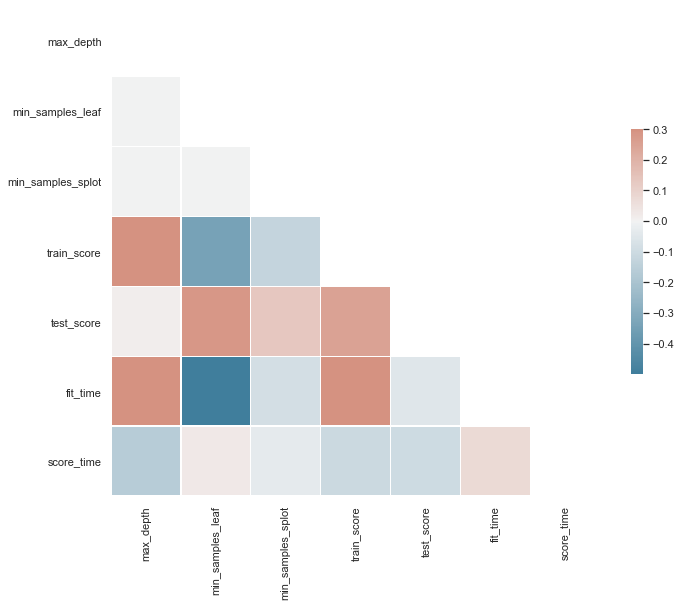

In [232]:
corr = resultados.corr()

sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

resultados.sort_values(by='test_score', ascending=False)[:5]

# Explorando espaço de hiper parametros com GridSeachCV

In [233]:
from sklearn.model_selection import GridSearchCV

SEED = 301
np.random.seed(SEED)

espaco_de_parametros = dict(
    max_depth = [3,5],
    min_samples_leaf = [32,64,128],
    min_samples_split = [32,64,128],
    criterion = ['gini', 'entropy']

)

busca = GridSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    cv = GroupKFold(n_splits = 10))
busca.fit(x_azar, y_azar, groups = dados.modelo)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.017501,0.010463,0.003499,0.002655,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
1,0.010999,0.001414,0.002600,0.000490,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
2,0.008202,0.000979,0.002701,0.002491,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
3,0.007988,0.000633,0.001500,0.000501,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
4,0.008904,0.002336,0.001693,0.000633,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1


In [234]:
print(busca.best_params_)
print(round(busca.best_score_*100, 2))



{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 32, 'min_samples_split': 32}
78.67


In [235]:
melhor = busca.best_estimator_
melhor

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)

In [236]:
from sklearn.metrics import accuracy_score

# Evitar essa abordagem pois é muito otimista

predictions = melhor.predict(x_azar)
accuracy = accuracy_score(predictions, y_azar) * 100
print('Accuracy para os dados foi de %.2f%%' % accuracy)

Accuracy para os dados foi de 78.75%


# Como ter uma estimativa sem esse vicio nos dados que ja vi?
No caso de cross validations com busca de hiperparametros, fazemos uma nova validação cruzada. Chama-se nasted cross validation

In [237]:
from sklearn.model_selection import cross_val_score, KFold

busca = GridSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    cv = KFold(n_splits = 5, shuffle=True))
busca.fit(x_azar, y_azar)
scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
scores

array([0.782 , 0.784 , 0.791 , 0.781 , 0.7965])

In [238]:
def imprime_score(score):
  media = score.mean() * 100
  desvio = score.std() * 100
  print("Accuracy médio %.2f" % media)
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))
imprime_score(scores)

Accuracy médio 78.69
Intervalo [77.50, 79.88]


In [239]:
melhor = busca.best_estimator_
print(melhor)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)


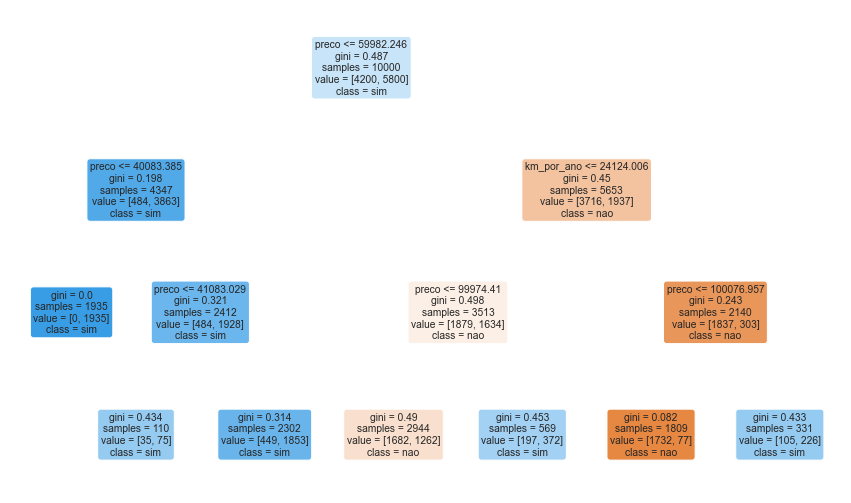

In [240]:
plt.figure(figsize=(15,9))
plot_tree(melhor, feature_names=x_azar.columns, filled=True, class_names=['nao', 'sim'], rounded=True)
plt.show()